## Imports

In [8]:
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM, AutoModelForCausalLM , AutoTokenizer, pipeline, RobertaTokenizer, RobertaForMaskedLM, AlbertTokenizer, AlbertModel, AlbertForMaskedLM
import logging
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import pandas as pd
import re
from tqdm import tqdm
import unidecode
from time import sleep
import json
import json
import statistics 
logging.basicConfig(level=logging.INFO)# OPTIONAL
import numpy as np; np.random.seed(42)
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D

## MAC Settings

In [9]:
print(f"PyTorch version: {torch.__version__}")
# Set the device      
device = "mps" if torch.backends.mps.is_available() else torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

PyTorch version: 1.13.1
Using device: mps


## Definitions

In [10]:
#TEMPLATES
EVALUATION_PATH = '../data/evaluation/'
RESULTS_PATH = '../data/results/'
ALBERT_BASE_TEMPLATE_1 = 'ALBERTbase[1]'
ALBERT_BASE_TEMPLATE_5 = 'ALBERTbase[5]'
ALBERT_LARGE_TEMPLATE_1 = 'ALBERTlarge[1]'
ALBERT_LARGE_TEMPLATE_5 = 'ALBERTlarge[5]'
BERT_BASE_TEMPLATE_1 = 'BERTbase[1]'
BERT_BASE_TEMPLATE_5 = 'BERTbase[5]'
BERT_LARGE_TEMPLATE_1 = 'BERTlarge[1]'
BERT_LARGE_TEMPLATE_5 = 'BERTlarge[5]'
ROBERTA_BASE_TEMPLATE_1 = 'RoBERTabase[1]'
ROBERTA_BASE_TEMPLATE_5 = 'RoBERTabase[5]'
ROBERTA_LARGE_TEMPLATE_1 = 'RoBERTalarge[1]'
ROBERTA_LARGE_TEMPLATE_5 = 'RoBERTalarge[5]'
BERTWEET_BASE_TEMPLATE_1 = 'BERTweetbase[1]'
BERTWEET_BASE_TEMPLATE_5 = 'BERTweetbase[5]'
BERTWEET_LARGE_TEMPLATE_1 = 'BERTweetlarge[1]'
BERTWEET_LARGE_TEMPLATE_5 = 'BERTweetlarge[5]'

MODELS =[ALBERT_BASE_TEMPLATE_1, ALBERT_BASE_TEMPLATE_5, ALBERT_LARGE_TEMPLATE_1, ALBERT_LARGE_TEMPLATE_5, 
         BERT_BASE_TEMPLATE_1, BERT_BASE_TEMPLATE_5, BERT_LARGE_TEMPLATE_1, BERT_LARGE_TEMPLATE_5,
         ROBERTA_BASE_TEMPLATE_1, ROBERTA_BASE_TEMPLATE_5, ROBERTA_LARGE_TEMPLATE_1, ROBERTA_LARGE_TEMPLATE_5,
         BERTWEET_BASE_TEMPLATE_1, BERTWEET_BASE_TEMPLATE_5, BERTWEET_LARGE_TEMPLATE_1, BERTWEET_LARGE_TEMPLATE_5]

MODELS_NAMES = ['ALBERTbase[1]','ALBERTbase[5]','ALBERTlarge[1]','ALBERTlarge[5]',
                'BERTbase[1]','BERTbase[5]','BERTlarge[1]','BERTlarge[5]', 
                'RoBERTabase[1]','RoBERTabase[5]','RoBERTalarge[1]','RoBERTalarge[5]',
                'BERTweetbase[1]','BERTweetbase[5]','BERTweetlarge[1]','BERTweetlarge[5]']

NEO_ROW = 0
NEUTRAL_ROW = 1
BINARY_ROW = 2
QUEER_IDENTITY = 3
QUEER_ORIENTATION = 4
QUEER_OTHER = 5
NON_QUEER_IDENTITY = 6
NON_QUEER_ORIENTATION = 7
NON_QUEER_OTHER = 8
QUEER_ROW = 9
NON_QUEER_ROW = 10 

#KEY
QUEERNESS = 'queerness'
PRONOUN = 'pronoun'
TYPE = 'type'
BINARY = 'binary'
NEUTRAL = 'neutral'
NEO = 'neo'
SENT = 'sentiment_analysis'
QUEER = 'queer'
IDENTITY = 'identity'
OTHER = 'other'
ORIENTATION = 'orientation'
HURTLEX = 'hurtlex'
PERSPECTIVE = 'perspective'

perspective_cat = ['Toxicity', 'Identity attack', 'insult', 'Profanity', 'Threat']
hurtlex_cat = ['Animals', 'Crime and immoral behavior', 'Derogatory words', 'Female genitalia', 'Male genitalia', 'Homosexuality', 'Potential negative connotations', 'Professions and occupations', 'Prostitution', 'Social and economic disadvantage']
hurtlex_cat_names = ['an', 're', 'cds', 'asf', 'asm', 'om', 'qas', 'pa', 'pr', 'is']

### Utils

In [11]:
# def get_model_name(model):
#     if model == ALBERT_BASE_TEMPLATE_1:
#         return 'ALBERT base [1]'
#     elif model == ALBERT_BASE_TEMPLATE_5:
#         return 'ALBERT base [5]'
#     elif model == ALBERT_LARGE_TEMPLATE_1:
#         return 'ALBERT large [1]'
#     elif model == ALBERT_LARGE_TEMPLATE_5:
#         return 'ALBERT large [5]'
#     elif model == BERT_BASE_TEMPLATE_1:
#         return 'BERT base [1]'
#     elif model == BERT_BASE_TEMPLATE_5:
#         return 'BERT base [5]'
#     elif model == BERT_LARGE_TEMPLATE_1:
#         return 'BERT large [1]'
#     elif model == BERT_LARGE_TEMPLATE_5:
#         return 'BERT base [5]'
#     elif model == ROBERTA_BASE_TEMPLATE_1:
#         return 'RoBERTa base [1]'
#     elif model == ROBERTA_BASE_TEMPLATE_5:
#         return 'RoBERTa base [5]'
#     elif model == ROBERTA_LARGE_TEMPLATE_1:
#         return 'RoBERTa large [1]'
#     elif model == ROBERTA_LARGE_TEMPLATE_5:
#         return 'RoBERTa large [5]'
#     elif model == BERTWEET_BASE_TEMPLATE_1:
#         return 'BERTweet base [1]'
#     elif model == BERTWEET_BASE_TEMPLATE_5:
#         return 'BERTweet base [5]'
#     elif model == BERT_LARGE_TEMPLATE_1:
#         return 'BERTweet large [1]'
#     elif model == BERT_LARGE_TEMPLATE_5:
#         return 'BERTweet large [5]'

def truncate_float(float_number, decimal_places = 2):
    multiplier = 10 ** decimal_places
    return int(float_number * multiplier) / multiplier

# Graph

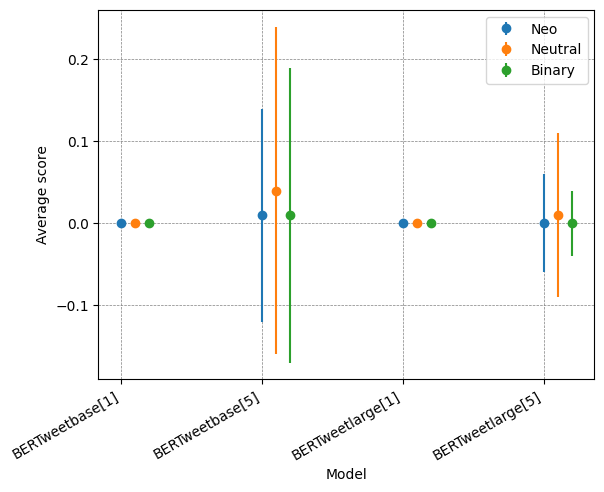

In [12]:
def error_bar(models):
    x = []
    y1_neo, y2_neutral, y3_binary= [], [], []
    yerr1_neo, yerr2_neutral, yerr3_binary = [], [], []
    for m in models:
        csv = pd.read_csv(RESULTS_PATH+m+'_afinn.csv', sep=";")
        x.append(m)
        y1_neo.append(csv.loc[NEO_ROW]['Score'])
        y2_neutral.append(csv.loc[NEUTRAL_ROW]['Score'])
        y3_binary.append(csv.loc[BINARY_ROW]['Score'])
        yerr1_neo.append(csv.loc[NEO_ROW]['StDev'])
        yerr2_neutral.append(csv.loc[NEUTRAL_ROW]['StDev'])
        yerr3_binary.append(csv.loc[BINARY_ROW]['StDev'])
    #x = list("ABC")
    #y1_neo, y2_neutral, y3_binary= [0.5, 1.2, 0.7], [0.7, 1.5, 2], [1.7, 0.5, 2]
    #yerr1_neo, yerr2_neutral, yerr3_binary = np.random.rand(3, len(x))*4+0.3
    # print(y1_neo)
    # print(y2_neutral)
    # print(y3_binary)
    fig, ax = plt.subplots()
    plt.style.use('default')
    plt.xticks(rotation=30)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
   
    
    
    trans1 = Affine2D().translate(0.0, 0.0) + ax.transData
    trans2 = Affine2D().translate(+0.1, 0.0) + ax.transData
    trans3 = Affine2D().translate(+0.2, 0.0) + ax.transData
    er1 = ax.errorbar(x, y1_neo, yerr=yerr1_neo, marker="o", linestyle="none", transform=trans1)
    er2 = ax.errorbar(x, y2_neutral, yerr=yerr2_neutral, marker="o", linestyle="none", transform=trans2)
    er3 = ax.errorbar(x, y3_binary, yerr=yerr3_binary, marker="o", linestyle="none", transform=trans3)
    plt.ylabel("Average score")
    plt.xlabel("Model")
    ax.legend(['Neo', 'Neutral', 'Binary'])
    plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    plt.show()

error_bar([BERTWEET_BASE_TEMPLATE_1, BERTWEET_BASE_TEMPLATE_5,BERTWEET_LARGE_TEMPLATE_1, BERTWEET_LARGE_TEMPLATE_5])

5194.0
1378.0
27.0
1.9593613933236573
5194.0
1378.0
116.0
8.417997097242381
5194.0
1378.0
61.0
4.426705370101597
5194.0
1378.0
11.0
0.7982583454281567
[[2.7339237581825184, 8.009241432422025, 4.620716211012707, 1.5787447054293418], [2.464381979206777, 7.83596457450905, 4.004620716211012, 3.234501347708895], [1.001155179052753, 3.2922603003465536, 2.964959568733154, 0.28879476318829417], [0.03850596842510589, 0.13477088948787064, 0.07701193685021178, 0.0], [0.6738544474393532, 2.0793222949557184, 0.2117828263380824, 0.0]]
[[1.9593613933236573, 8.417997097242381, 4.426705370101597, 0.7982583454281567], [1.6690856313497822, 6.386066763425253, 2.9027576197387517, 2.467343976777939], [0.6531204644412192, 3.9187227866473147, 3.483309143686502, 0.0], [0.07256894049346879, 0.43541364296081275, 0.36284470246734396, 0.0], [0.8708272859216255, 3.3381712626995643, 0.0, 0.0]]
[6.91, 21.35, 11.87, 5.1]
[5.22, 22.49, 11.17, 3.26]


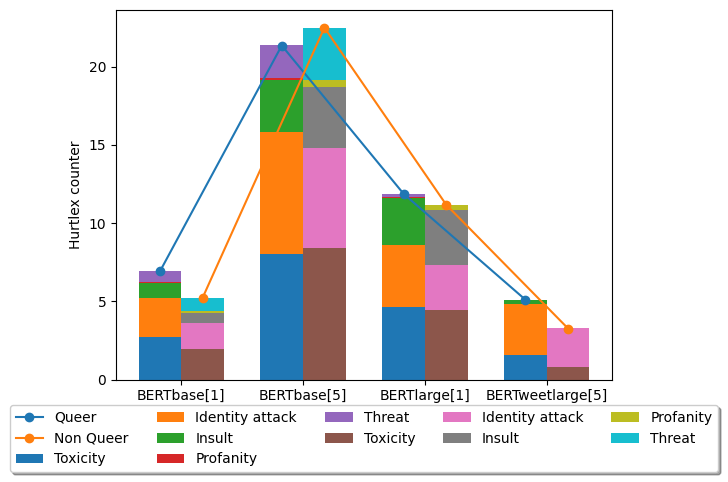

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def draw_double_bar_and_double_line_graph(models):
    x_labels, bar_data1, bar_data2, line_data1, line_data2 = [], [], [], [], []
    tox_queer, id_queer, ins_queer, prof_queer, thre_queer, tox_non, id_non, ins_non, prof_non, thre_non = [], [], [], [], [], [], [], [], [], []
    line_data1, line_data2 = [], []
    for m in models:
        csv = pd.read_csv(RESULTS_PATH+m+'_perspective.csv', sep=";", index_col=[0])
        queer_tot = csv.loc['Queer']['Tot']
        non_queer_tot = csv.loc['Non Queer']['Tot']
        print(queer_tot)
        print(non_queer_tot)
        x_labels.append(m)
        tox_queer.append( (csv.loc['Queer']['Toxicity']/queer_tot              )*100)
        id_queer.append(  (csv.loc['Queer']['Identity attack']/queer_tot       )*100)
        ins_queer.append( (csv.loc['Queer']['Insult']        /queer_tot        )*100)
        prof_queer.append((csv.loc['Queer']['Profanity']    /queer_tot         )*100)
        thre_queer.append((csv.loc['Queer']['Threat']       /queer_tot         )*100)

        print (csv.loc['Non Queer']['Toxicity'])
        print ((csv.loc['Non Queer']['Toxicity']      /non_queer_tot)*100)
        tox_non.append(   (csv.loc['Non Queer']['Toxicity']      /non_queer_tot)*100)
        id_non.append(    (csv.loc['Non Queer']['Identity attack']/non_queer_tot)*100)
        ins_non.append(   (csv.loc['Non Queer']['Insult']        /non_queer_tot)*100)
        prof_non.append(  (csv.loc['Non Queer']['Profanity']    /non_queer_tot )*100)
        thre_non.append(  (csv.loc['Non Queer']['Threat']       /non_queer_tot )*100)

        line_data1.append(csv.loc['Queer']['Score'])
        line_data2.append(csv.loc['Non Queer']['Score'])
    bar_data1.append(tox_queer)
    bar_data1.append(id_queer)
    bar_data1.append(ins_queer)
    bar_data1.append(prof_queer)
    bar_data1.append(thre_queer)
    bar_data2.append(tox_non)
    bar_data2.append(id_non)
    bar_data2.append(ins_non)
    bar_data2.append(prof_non)
    bar_data2.append(thre_non)
    print(bar_data1)
    print(bar_data2)
    print(line_data1)
    print(line_data2)

       
    #Set the width of the bars
    bar_width = 0.35
    # Create an array of x values for the bars
    x = np.arange(len(x_labels))
    # Create the figure and axis objects
    fig, ax1 = plt.subplots()
    # Predefined colors for bars and lines
    bar_colors = ['blue', 'green']
    bar_colors2 = ['orange', 'violet']
    line_colors = ['red', 'purple']

    # Create the first set of bars
    perpective_col = ['Toxicity', 'Identity attack', 'Insult', 'Profanity', 'Threat']
    bottom1 = np.zeros(len(x_labels))
    for i, data in enumerate(bar_data1):
        ax1.bar(x - bar_width/2, data, width=bar_width, label=f'{perpective_col[i]}', bottom=bottom1)
        bottom1 += data

    # Create the second set of bars
    bottom2 = np.zeros(len(x_labels))
    for i, data in enumerate(bar_data2):
        ax1.bar(x + bar_width/2, data, width=bar_width, label=f'{perpective_col[i]}', bottom=bottom2)
        bottom2 += data

    # Create the first set of line plots
    #ax2 = ax1.twinx()  # Create a twin y-axis
    ax1.plot(x - bar_width/2, line_data1, marker='o', label='Queer')
    
    # Create the second set of line plots
    ax1.plot(x + bar_width/2, line_data2, marker='o', label='Non Queer')

    # Set labels and legends
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Hurtlex counter', color='black')
    #ax1.set_ylabel('Score', color='black')
    ax1.set_xticks(x)
    ax1.set_xticklabels(x_labels)
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
    #ax2.legend(loc='upper left', bbox_to_anchor=(0.05, 0.87))

    # Show the graph
    plt.show()

# Example usage:
# x_labels = ['A', 'B', 'C', 'D']
# bar_data1 = [[10, 20, 30, 40], [15, 25, 35, 45]]
# bar_data2 = [[5, 15, 25, 35], [20, 10, 30, 40]]
# line_data1 = [50, 55, 60, 65]
# line_data2 = [45, 60, 50, 70]

draw_double_bar_and_double_line_graph([BERT_BASE_TEMPLATE_1, BERT_BASE_TEMPLATE_5, BERT_LARGE_TEMPLATE_1, BERTWEET_LARGE_TEMPLATE_5])


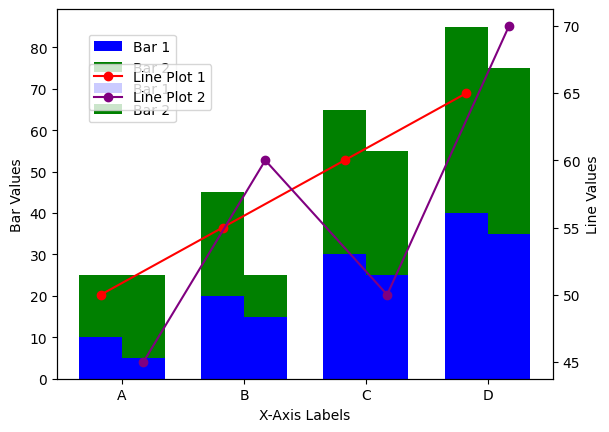

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def draw_double_bar_and_double_line_graph(x_labels, bar_data1, bar_data2, line_data1, line_data2):
    """
    Create a graph with two bars and two lines per x-axis element.

    Args:
    - x_labels: Labels for the x-axis.
    - bar_data1: List of lists for the first set of stacked bars.
    - bar_data2: List of lists for the second set of stacked bars.
    - line_data1: List of values for the first line plot.
    - line_data2: List of values for the second line plot.

    Returns:
    - None (displays the graph).
    """
    # Set the width of the bars
    bar_width = 0.35

    # Create an array of x values for the bars
    x = np.arange(len(x_labels))

    # Create the figure and axis objects
    fig, ax1 = plt.subplots()

    # Predefined colors for bars and lines
    bar_colors = ['blue', 'green']
    line_colors = ['red', 'purple']

    # Create the first set of bars
    bottom1 = np.zeros(len(x_labels))
    for i, data in enumerate(bar_data1):
        ax1.bar(x - bar_width/2, data, width=bar_width, label=f'Bar {i+1}', color=bar_colors[i], bottom=bottom1)
        bottom1 += data

    # Create the second set of bars
    bottom2 = np.zeros(len(x_labels))
    for i, data in enumerate(bar_data2):
        ax1.bar(x + bar_width/2, data, width=bar_width, label=f'Bar {i+1}', color=bar_colors[i], bottom=bottom2)
        bottom2 += data

    # Create the first set of line plots
    ax2 = ax1.twinx()  # Create a twin y-axis
    ax2.plot(x - bar_width/2, line_data1, marker='o', color=line_colors[0], label='Line Plot 1')
    
    # Create the second set of line plots
    ax2.plot(x + bar_width/2, line_data2, marker='o', color=line_colors[1], label='Line Plot 2')

    # Set labels and legends
    ax1.set_xlabel('X-Axis Labels')
    ax1.set_ylabel('Bar Values', color='black')
    ax2.set_ylabel('Line Values', color='black')
    ax1.set_xticks(x)
    ax1.set_xticklabels(x_labels)
    ax1.legend(loc='upper left', bbox_to_anchor=(0.05, 0.95))
    ax2.legend(loc='upper left', bbox_to_anchor=(0.05, 0.87))

    # Show the graph
    plt.show()

# Example usage:
x_labels = ['A', 'B', 'C', 'D']
bar_data1 = [[10, 20, 30, 40], [15, 25, 35, 45]]
bar_data2 = [[5, 15, 25, 35], [20, 10, 30, 40]]
line_data1 = [50, 55, 60, 65]
line_data2 = [45, 60, 50, 70]

draw_double_bar_and_double_line_graph(x_labels, bar_data1, bar_data2, line_data1, line_data2)
